# SETUP

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MINIST
获取MNIST数据

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="./datasets")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

#### 获取不到MNIST数据，另外使用 "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 获取的数据。

In [3]:
def fetch_mldata_alternative():
    from six.moves import urllib
    from sklearn.datasets import fetch_mldata
    try:
        # mnist = fetch_mldata('MNIST original')
        mnist = fetch_mldata('MNIST original', data_home='./datasets')
    except:
        print("Could not download MNIST data from mldata.org, trying alternative...")

        # Alternative method to load MNIST, if mldata.org is down
        from scipy.io import loadmat
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        mnist_path = "./mnist-original.mat"
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        mnist = {
            "data": mnist_raw["data"].T,
            "target": mnist_raw["label"][0],
            "COL_NAMES": ["label", "data"],
            "DESCR": "mldata.org dataset: mnist-original",
        }
        print("Success!")
    return mnist

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

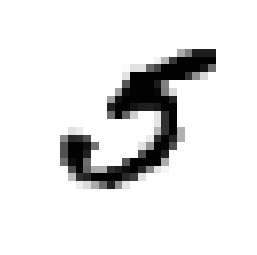

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


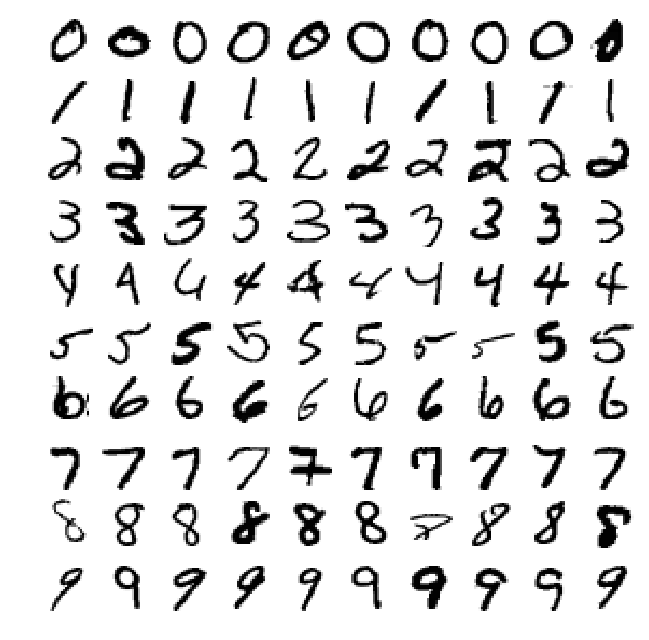

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
y[36000]

5.0

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[:6000]

In [12]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练一个二分类器

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

# 对性能的评估

## 使用交叉验证测量准确性

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
   

0.9502
0.96565
0.96495


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

#### 总是返回False的模型也有90+%的准确率

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

## 混淆矩阵

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

#### 一个完美的分类器将只有真反例和真正例，所以混淆矩阵的非零值仅在其主对角线（左上至右下）

In [21]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 准确率与召回率

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [23]:
4177 / (4177 + 844)

0.8319059948217487

In [24]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [25]:
4177 / (4177 + 1244)

0.7705220439033389

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [28]:
threshhold = 0
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

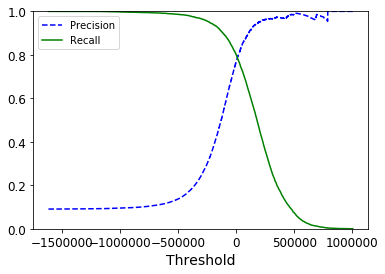

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [33]:
y_train_pred_90 = (y_scores > 70000)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

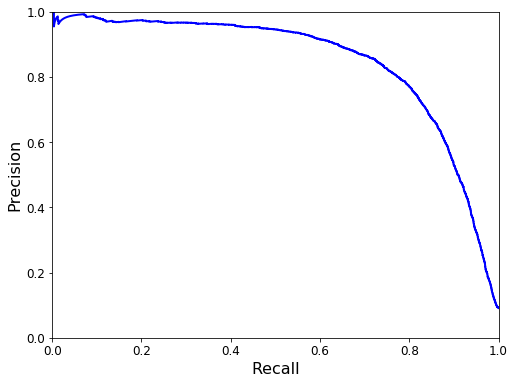

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC曲线

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

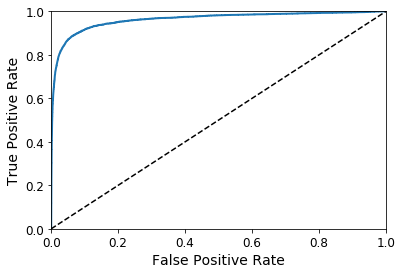

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_roc_curve(fpr, tpr)
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967155

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

c:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [41]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

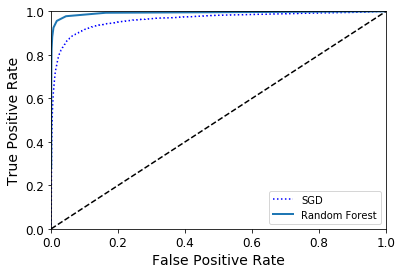

In [42]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

# 多类分类

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [48]:
sgd_clf.classes_[5]

5.0

In [49]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

# 误差分析

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

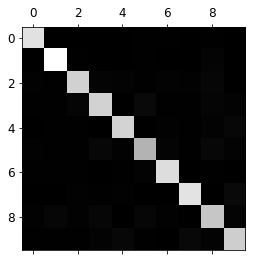

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

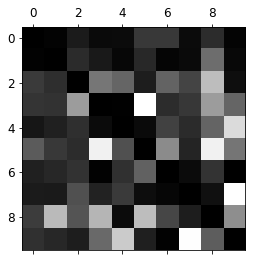

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

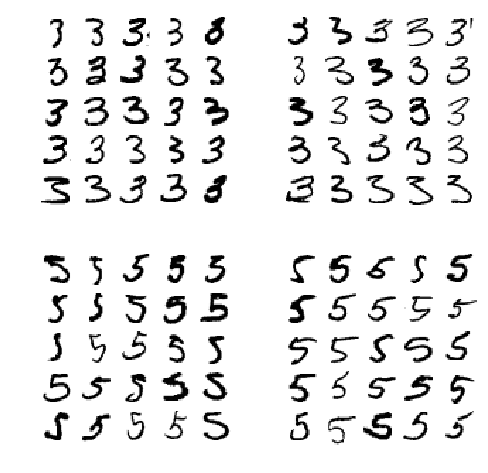

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 多标签分类

In [60]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

#### 这个需要很长时间

In [ ]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average="macro")

# 多输出分类

In [62]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


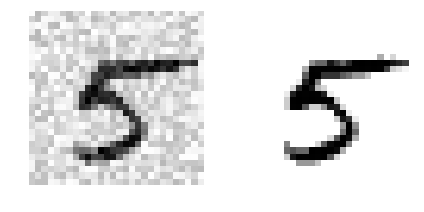

In [63]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

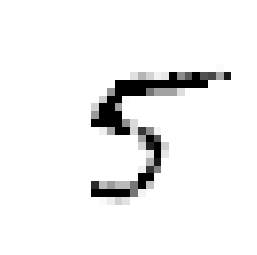

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)